In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# reading the time series (pd.Series format)
series = pd.read_csv('all_weather.csv')

tseries = series['t_out']
# you can simulate some data with:
# tseries = pd.Series(np.random.random(100))

rhseries = series['rh_out']

# Heat Wave Index

In [30]:
def C_F(T):
    return (T*9/5) + 32

def F_HI(series):
    # Heat index calculation
    heat_i = []
    c1 = -42.379
    c2 = 2.04901523
    c3 = 10.14333127
    c4 = -0.22475541
    c5 = -6.83783e-03
    c6 = -5.481717e-02
    c7 = 1.22874e-03
    c8 = 8.5282e-04
    c9 = -1.99e-06

    for i in range(len(series)):
        if C_F(series['t_out'][i]) < 80:
            index = 0.5*(C_F(series['t_out'][i]) + 61 + (C_F(series['t_out'][i]) - 68)*1.2 + (series['rh_out'][i]*0.094))
            heat_i.append(index)
            # print(index)
        else:
            index = c1 + c2*C_F(series['t_out'][i]) + c3*series['rh_out'][i] + c4*C_F(series['t_out'][i])*series['rh_out'][i] + c5*C_F(series['t_out'][i])**2 + c6*series['rh_out'][i]**2 + c7*C_F(series['t_out'][i])**2*series['rh_out'][i] + c8*C_F(series['t_out'][i])*series['rh_out'][i]**2 + c9*C_F(series['t_out'][i])**2*series['rh_out'][i]**2
            heat_i.append(index)

    series['heat_index'] = heat_i

    return series

In [31]:
series = F_HI(series)

In [32]:
series['datetime_UTC'] = pd.to_datetime(series['datetime_UTC'], utc=True).dt.tz_convert('America/Los_Angeles')
series['hour_of_day'] = series['datetime_UTC'].dt.hour

In [33]:
series.groupby('hour_of_day').describe()

t_out                                                       \
              count       mean       std   min        25%   50%      75%   
hour_of_day                                                                
0            1823.0  12.639309  5.501424  0.00   8.300000  12.8  17.2000   
1            1830.0  12.121960  5.398299 -0.60   7.808333  12.2  16.7000   
2            1820.0  11.689806  5.327405 -1.70   7.800000  11.7  16.1000   
3            1825.0  11.306662  5.222860 -1.10   7.200000  11.7  15.6000   
4            1826.0  10.930413  5.161620 -2.20   7.200000  11.1  15.0000   
5            1826.0  10.608296  5.094900 -2.80   6.700000  11.1  14.4000   
6            1825.0  10.631191  5.294510 -2.80   6.700000  11.1  14.4000   
7            1821.0  11.795610  5.562392 -1.10   7.800000  12.2  16.1000   
8            1820.0  14.053594  5.561526  0.00   9.400000  13.9  18.3000   
9            1819.0  16.211946  5.928145  1.10  11.100000  16.1  21.1000   
10           1823.0  18.248105  6.390893  1.10  12.800000  18.3  23.3000   
11           1823.0  20.050404  6.888543  1.95  14.400000  20.0  25.6000   
12           1825.0  21.562818  7.379844  2.50  15.000000  21.7  27.8000   
13           1825.0  22.690488  7.830675  3.90  16.100000  22.8  29.4000   
14           1825.0  23.427902  8.226630  4.40  16.100000  23.3  30.6000   
15           1825.0  23.625263  8.578195  4.40  16.100000  23.9  31.1000   
16           1826.0  23.026760  9.001132  4.40  14.400000  22.8  30.6000   
17           1824.0  21.730372  9.182819  4.20  13.300000  21.7  29.7750   
18           1826.0  19.835509  8.734167  3.60  11.800000  19.4  27.2000   
19           1826.0  17.781481  7.758794  2.80  11.100000  17.2  24.2875   
20           1826.0  16.094789  6.868590  2.80  10.000000  15.6  21.7000   
21           1825.0  14.895556  6.279068  1.70  10.000000  14.4  20.0000   
22           1826.0  13.963709  5.886068  0.60   9.400000  13.9  18.9000   
23           1824.0  13.222719  5.651474  0.60   8.900000  13.3  17.8000   

                   rh_out             ...      long           heat_index  \
              max   count       mean  ...       75%       max      count   
hour_of_day                           ...                                  
0            27.8  1823.0  75.008723  ... -121.4944 -121.4944     1823.0   
1            27.8  1830.0  76.928191  ... -121.4944 -121.4944     1830.0   
2            27.8  1820.0  78.436096  ... -121.4944 -121.4944     1820.0   
3            26.7  1825.0  79.739989  ... -121.4944 -121.4944     1825.0   
4            27.2  1826.0  81.165973  ... -121.4944 -121.4944     1826.0   
5            28.6  1826.0  82.252462  ... -121.4944 -121.4944     1826.0   
6            31.1  1825.0  82.246645  ... -121.4944 -121.4944     1825.0   
7            30.0  1821.0  78.897990  ... -121.4944 -121.4944     1821.0   
8            31.7  1820.0  70.982062  ... -121.4944 -121.4944     1820.0   
9            36.1  1819.0  63.094062  ... -121.4944 -121.4944     1819.0   
10           37.2  1823.0  56.181166  ... -121.4944 -121.4944     1823.0   
11           40.0  1823.0  50.426382  ... -121.4944 -121.4944     1823.0   
12           42.2  1825.0  45.695526  ... -121.4944 -121.4944     1825.0   
13           43.3  1825.0  42.389373  ... -121.4944 -121.4944     1825.0   
14           44.4  1824.0  40.180234  ... -121.4944 -121.4944     1824.0   
15           45.6  1825.0  39.495685  ... -121.4944 -121.4944     1825.0   
16           45.0  1823.0  41.362056  ... -121.4944 -121.4944     1823.0   
17           45.0  1824.0  45.468056  ... -121.4944 -121.4944     1824.0   
18           41.7  1826.0  51.254073  ... -121.4944 -121.4944     1826.0   
19           37.2  1826.0  57.499762  ... -121.4944 -121.4944     1826.0   
20           33.9  1826.0  62.954195  ... -121.4944 -121.4944     1826.0   
21           32.2  1825.0  67.018075  ... -121.4944 -121.4944     1825.0   
22           31.1  1826.0  70.362735  ... -121.4944 -121.4944

In [34]:
w1series = series[series['hour_of_day'].between(10, 14)]
w1series = w1series['heat_index'].values
hist1_wout = np.histogram(w1series[np.isfinite(w1series)], bins=100)
w1out_dist = scipy.stats.rv_histogram(hist1_wout)
print(w1out_dist.pdf(98))

w2series = series[series['hour_of_day'].between(15, 19)]
w2series = w2series['heat_index'].values
hist2_wout = np.histogram(w2series[np.isfinite(w2series)], bins=100)
w2out_dist = scipy.stats.rv_histogram(hist2_wout)
print(w2out_dist.pdf(98))

0.0025639469168663473
0.0036237565397364865


In [35]:
p_x = scipy.stats.norm(90, 5)
p_x.pdf(98)

0.02218416693589111

<ipython-input-36-baecacd68240>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


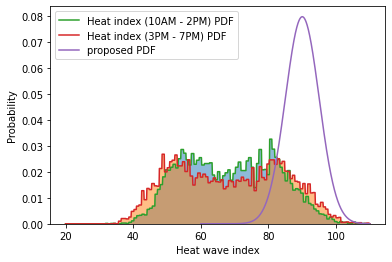

In [36]:
X1 = np.linspace(20, 110, 1000)
X2 = np.linspace(60, 110, 1000)
fig, ax = plt.subplots()
ax.hist(w1series, density=True, bins=100, alpha = 0.5)
ax.hist(w2series, density=True, bins=100, alpha = 0.5)
ax.plot(X1, w1out_dist.pdf(X1), label='Heat index (10AM - 2PM) PDF')
ax.plot(X1, w2out_dist.pdf(X1), label='Heat index (3PM - 7PM) PDF')
ax.plot(X2, p_x.pdf(X2), label='proposed PDF')
ax.set_xlabel('Heat wave index')
ax.set_ylabel('Probability')
ax.legend()
fig.show()

# Building Energy Profile

In [37]:
data = pd.read_csv("./building_energy/building_energy.csv", compression='gzip')
data['w_out'] = series['heat_index']
data['time'] = pd.to_datetime(data['time'])
data['day_of_week'] = data['time'].dt.day_of_week
data['hour'] = data['time'].dt.hour
data['time_of_week'] = data['hour'] + data['day_of_week']*24
data['w_out'] = data['w_out'].interpolate()

In [38]:
X = data[['w_out', 'time_of_week']].values
y = data['towt']

In [39]:
from sklearn import linear_model
model = linear_model.LinearRegression(normalize = True)
model.fit(X, y)

/Users/Bird/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [40]:
coef = model.coef_
intercept = model.intercept_
print('coef= ', coef)
print('intercept= ', intercept)

coef=  [ 1.27970652 -0.02117052]
intercept=  -6.885072481859581


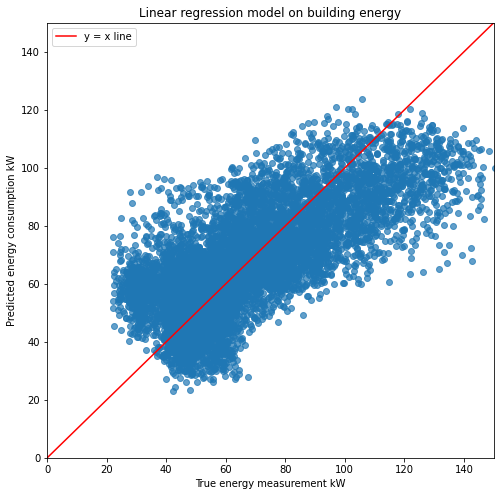

In [41]:
plt.figure(figsize=[8, 8])
plt.scatter(y, model.predict(X), alpha = 0.7)
plt.plot(np.linspace(0, 150, 100), np.linspace(0, 150, 100), 'r', label = 'y = x line')
plt.xlim(0, 150)
plt.ylim(0, 150)
plt.xlabel('True energy measurement kW')
plt.ylabel('Predicted energy consumption kW')
plt.title("Linear regression model on building energy")
plt.legend()

<ipython-input-42-af871bd195ff>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


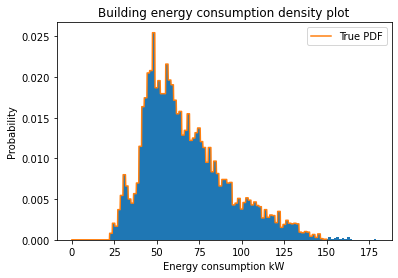

In [42]:
# Fit building energy distribution
energy_series = data['towt']
hist = np.histogram(energy_series[np.isfinite(energy_series)], bins=100)
build_dist = scipy.stats.rv_histogram(hist)

# Visualize building energy and EV power distribution
X1 = np.linspace(0, 150, 1000)
X2 = np.linspace(0, 40, 1000)
fig, ax = plt.subplots()
ax.hist(energy_series, density=True, bins=100)
ax.plot(X1, build_dist.pdf(X1), label='True PDF')
ax.set_xlabel('Energy consumption kW')
ax.set_ylabel('Probability')
ax.set_title('Building energy consumption density plot')
ax.legend()
fig.show()

# EV Charging

In [43]:
# Assume EV SOC
SOC_x = scipy.stats.norm(50, 10)
SOC_x.pdf(25)

0.001752830049356854

In [44]:
# define function EV
def EV_status(SOC, DR):
    """
    This is a function defined to simulate EV charging and discharging process

    Args:
        SOC: EV level of SOC (array)
        DR: weather DR is activated

    Returns:
        EV: Total power output from EV charging/discharging simulation (negative: net EV discharging)
        SOC_nex: EV level of SOC after the hour (array)
    """
    EV = 0
    SOC_next = []
    if DR == True:
        for i in SOC:
            if i > 50:
                # Assume discharging rate 2kW/hr
                EV = EV - 2
                SOC_next.append(i - 1)
            else:
                EV = 0
    else:
        for i in SOC:
            # Assume charging rate 5kW/hr
            EV = EV + 5
            SOC_next.append(i + 5)

    return EV, SOC_next

In [45]:
# define function f(x)
def process(X, EV, DR, curtail = 0.15):
    """
    This is a function defined to simulate the functions (or actions) after the DR events

    Args:
        DR: weather DR is activated
        X: energy model prediction input (time_of_week, t_out)
        EV: EV charging
        curtail: expected curtailment level (default set as 15%)
    
    Returns:
        total: the total energy consumption of EV and building
        residual: Remaining energy curtailment load after combining EV action
    """
    build_energy = model.predict(X)

    if DR == True:
        curtailment = build_energy * curtail 
        total = build_energy + EV
        residual = curtailment + EV
        return total, residual
    else:
        total = build_energy + EV

        # Residual = 0 also indicates no DR event
        residual = 0
        return total, residual



# Simulation on EV and Building

In [46]:
total_energy = []
residual_energy = []
for i in range(1000):
    condition = False
    total = []
    residual = []

    # Assume 5 EV
    SOC_next = SOC_x.rvs(size = 5)

    # 10AM - 2PM DR simulation on EV and building
    for j in range(10, 14):
        w1_out = w1out_dist.rvs(size = 1)[0]
        X = [[w1_out, j]]

        # threshold set as heat wave index >= 95
        if w1_out >= 95:
            condition = True

        EV, SOC_next = EV_status(SOC_next, condition)
        total_temp, residual_temp = process(X, EV, condition)
            
        total.append(total_temp)
        residual.append(residual_temp)

    # Reset DR condition
    condition = False
    
    # 3PM - 7PM DR simulation on EV and building
    for j in range(15, 19):
        w2_out = w1out_dist.rvs(size = 1)[0]
        X = [[w2_out, j]]

        # threshold set as heat wave index >= 95
        if w2_out >= 95:
            condition = True

        EV, SOC_next = EV_status(SOC_next, condition)
        total_temp, residual_temp = process(X, EV, condition)
            
        total.append(total_temp)
        residual.append(residual_temp)
    
    total_energy.append(total)
    residual_energy.append(residual)


In [47]:
# residual_energy

# Sequential Monte Carlo Simulation

In [89]:
# Assuming EV charging distribution
from scipy.stats import uniform
from scipy.stats import norm

EV_charging = norm(50,10)
EV_discharge = norm(-30, 5)

In [90]:
class CurtailmentEstimateModel():
    '''
    Defines the model with 1 free params (Curtailment ratio)
    '''

    def __init__(self, EVcharge_dist, EVdischarge_dist):

        self.EV_charge = EVcharge_dist
        self.EV_discharge = EVdischarge_dist
    
    def evaluate_EV_BiCharging(self, params):
        
        results = []
        for p in params:
            E = p
            result = E + self.EV_charge.rvs(size = 1) + self.EV_discharge.rvs(size = 1) 
            
            results.append(result)
        return np.array(results)
    
    def evaluate_EV_Charging(self, params):
        
        results = []
        for p in params:
            E = p
            result = E + self.EV_charge.rvs(size = 1) 
            
            results.append(result)
        return np.array(results)
    
    def evaluate(self, params):
        results = []
        for p in params:
            E = p
            result = E
            results.append(result)

        return np.array(results)



0.00%|          | phi: 0.00000/1.0 [00:00<?

[ mutation ratio: n/a: : 0.00%|          | phi: 0.00000/1.0 [00:00<?

[ mutation ratio: 0.992: : 0.00%|          | phi: 0.00000/1.0 [00:00<?

[ mutation ratio: 0.996: : 0.02%|          | phi: 0.00017/1.0 [00:00<09:38

[ mutation ratio: 0.998: : 0.06%|          | phi: 0.00056/1.0 [00:00<04:10

[ mutation ratio: 0.998: : 0.16%|          | phi: 0.00161/1.0 [00:00<01:27

[ mutation ratio: 0.998: : 0.16%|          | phi: 0.00161/1.0 [00:00<01:27

[ mutation ratio: 0.998: : 0.43%|          | phi: 0.00431/1.0 [00:00<01:27

[ mutation ratio: 0.994: : 1.16%|          | phi: 0.01161/1.0 [00:00<01:26

[ mutation ratio: 0.994: : 2.84%|▎         | phi: 0.02841/1.0 [00:00<00:07

[ mutation ratio: 0.99: : 2.84%|▎         | phi: 0.02841/1.0 [00:00<00:07 

[ mutation ratio: 0.998: : 6.81%|▋         | phi: 0.06810/1.0 [00:00<00:07

[ mutation ratio: 0.996: : 15.38%|█▌        | phi: 0.15385/1.0 [00:00<00:06

[ mutation ratio: 0.996: : 23.97%|██▍       | phi:

marginal log likelihood = -4345.83513860289
parameter means = {'E': 67.36428874489968}


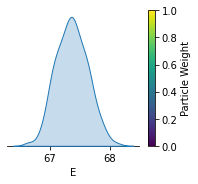

In [91]:
from smcpy.utils.plotter import plot_pairwise
from smcpy import AdaptiveSampler as Sampler
from smcpy import VectorMCMC, VectorMCMCKernel


# Initialize model
curtailment_model = CurtailmentEstimateModel(EV_charging, EV_discharge)

# Load data
std_dev = 25
building_data = data['towt'].tolist()

# Define prior distributions & MCMC kernel
priors = [norm(60, 25)]
vector_mcmc = VectorMCMC(curtailment_model.evaluate, building_data, priors, std_dev)
mcmc_kernel = VectorMCMCKernel(vector_mcmc, param_order=('E'))

# SMC sampling
smc = Sampler(mcmc_kernel)
step_list, mll_list = smc.sample(num_particles=500,
                                 num_mcmc_samples=5)

# Display results
print(f'marginal log likelihood = {mll_list[-1]}')
print(f'parameter means = {step_list[-1].compute_mean()}')

plot_pairwise(step_list[-1].params, step_list[-1].weights, save=True,
              param_names=['E'])

[ mutation ratio: 0.796: : 100.00%|██████████| phi: 1.00000/1.0 [00:08<00:00


marginal log likelihood = -4388.92686498017
parameter means = {'E': 16.942163568714108}


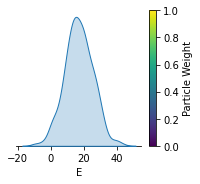

In [92]:
from smcpy.utils.plotter import plot_pairwise
from smcpy import AdaptiveSampler as Sampler
from smcpy import VectorMCMC, VectorMCMCKernel


# Initialize model
curtailment_model = CurtailmentEstimateModel(EV_charging, EV_discharge)

# Load data
std_dev = 25
building_data = data['towt'].tolist()

# Define prior distributions & MCMC kernel
priors = [norm(60, 25)]
vector_mcmc = VectorMCMC(curtailment_model.evaluate_EV_Charging, building_data, priors, std_dev)
mcmc_kernel = VectorMCMCKernel(vector_mcmc, param_order=('E'))

# SMC sampling
smc = Sampler(mcmc_kernel)
step_list, mll_list = smc.sample(num_particles=500,
                                 num_mcmc_samples=5)

# Display results
print(f'marginal log likelihood = {mll_list[-1]}')
print(f'parameter means = {step_list[-1].compute_mean()}')

plot_pairwise(step_list[-1].params, step_list[-1].weights, save=True,
              param_names=['E'])

[ mutation ratio: 0.778: : 100.00%|██████████| phi: 1.00000/1.0 [00:15<00:00

marginal log likelihood = -4396.508819351477
parameter means = {'E': 47.42250010992513}


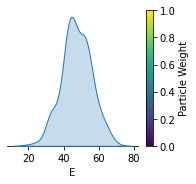

In [93]:
# Initialize model
state = 0
curtailment_model = CurtailmentEstimateModel(EV_charging, EV_discharge)

# Load data
std_dev = 25
building_data = data['towt'].tolist()

# Define prior distributions & MCMC kernel
priors = [norm(60, 10)]
vector_mcmc = VectorMCMC(curtailment_model.evaluate_EV_BiCharging, building_data, priors, std_dev)
mcmc_kernel = VectorMCMCKernel(vector_mcmc, param_order=('E'))

# SMC sampling
smc = Sampler(mcmc_kernel)
step_list, mll_list = smc.sample(num_particles=500,
                                 num_mcmc_samples=5)

# Display results
print(f'marginal log likelihood = {mll_list[-1]}')
print(f'parameter means = {step_list[-1].compute_mean()}')

plot_pairwise(step_list[-1].params, step_list[-1].weights, save=True,
              param_names=['E'])

<AxesSubplot:>

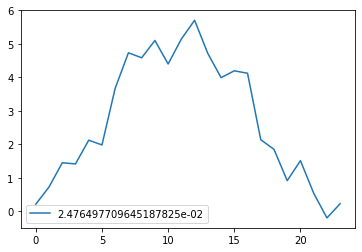

In [23]:
pd.read_csv('Example/noisy_data.txt').plot()

(22.18650189978103, 179.2346981642903, 24.87732535586826)

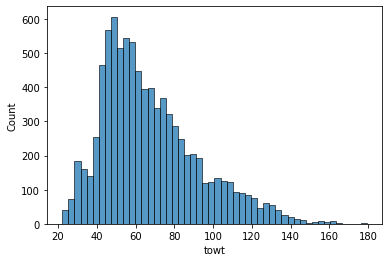

In [32]:
import seaborn as sns

sns.histplot(data['towt'])
min(data['towt']), max(data['towt']), np.std(data['towt'])

In [28]:
data['towt'].mean()

67.36956596391505

<AxesSubplot:ylabel='Count'>

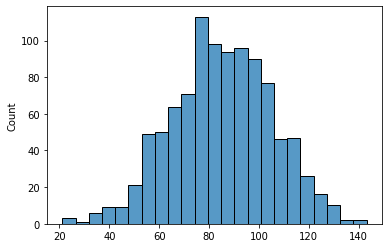

In [39]:
sns.histplot(norm(85,20).rvs(size=1000))